In [12]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)

In [13]:
import pandas as pd
import numpy as np
import torch

from PIL import Image
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from tqdm import tqdm

from src.image_dataset import SatelliteImageDataset


In [14]:
train_df = pd.read_excel("../data/raw/train.xlsx")
print("Total rows in train_df:", len(train_df))
train_df.head()

Total rows in train_df: 16209


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [15]:
image_dir = "../data/images/train"

available_image_ids = set(
    int(fname.replace(".jpg", ""))
    for fname in os.listdir(image_dir)
    if fname.endswith(".jpg")
)

train_df_filtered = train_df[
    train_df["id"].isin(available_image_ids)
].reset_index(drop=True)

print("Images on disk:", len(available_image_ids))
print("Filtered rows:", len(train_df_filtered))

Images on disk: 16034
Filtered rows: 16133


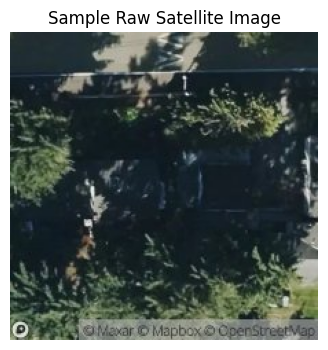

In [16]:
sample_id = train_df_filtered.loc[0, "id"]
image_path = f"{image_dir}/{sample_id}.jpg"

with Image.open(image_path) as img:
    image = img.convert("RGB")

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.title("Sample Raw Satellite Image")
plt.show()

In [17]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [18]:
train_dataset = SatelliteImageDataset(
    dataframe=train_df_filtered,
    image_dir=image_dir,
    transform=image_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0
)

# Sanity check one batch
images, ids = next(iter(train_loader))
print("Images batch shape:", images.shape)
print("IDs batch shape:", ids.shape)

Images batch shape: torch.Size([16, 3, 224, 224])
IDs batch shape: torch.Size([16])


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

resnet = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)

resnet.eval()
resnet.to(device)

feature_extractor = torch.nn.Sequential(
    *list(resnet.children())[:-1]
).to(device)

Using device: cpu


In [20]:
with torch.no_grad():
    images = images.to(device)
    features = feature_extractor(images)
    features = features.view(features.size(0), -1)

print("Feature batch shape:", features.shape)

Feature batch shape: torch.Size([16, 512])


In [21]:
all_embeddings = []
all_ids = []

resnet.eval()

with torch.no_grad():
    for images, ids in tqdm(train_loader):
        images = images.to(device)

        features = feature_extractor(images)
        features = features.view(features.size(0), -1)

        all_embeddings.append(features.cpu().numpy())
        all_ids.append(ids.cpu().numpy())

100%|██████████| 1009/1009 [10:31<00:00,  1.60it/s]


In [22]:
train_image_embeddings = np.vstack(all_embeddings)
train_image_ids = np.concatenate(all_ids)

print("Embeddings shape:", train_image_embeddings.shape)
print("IDs shape:", train_image_ids.shape)

assert train_image_embeddings.shape[0] == len(train_df_filtered)
assert train_image_embeddings.shape[1] == 512
assert len(train_image_ids) == len(train_df_filtered)

Embeddings shape: (16133, 512)
IDs shape: (16133,)


In [23]:
os.makedirs("../data/embeddings", exist_ok=True)

np.save("../data/embeddings/train_image_embeddings.npy", train_image_embeddings)
np.save("../data/embeddings/train_image_ids.npy", train_image_ids)

print("Train image embeddings saved successfully.")


Train image embeddings saved successfully.
